In [1]:
%reload_ext jupyter_black
%reload_ext autoreload
%autoreload 2
!date

Mon Jun 30 07:25:50 EDT 2025


# Anthropometric Trajectory Forecasting

**Author**: Hunter Merrill

### Background
This notebook began as a weekend project, mostly for fun. Brian told me that Elizabeth mentioned an interest in seeing forecasted trajectories of mid upper arm circumference (MUAC) and weight-for-height z-score (WFHZ). I borrowed a dataset he had already created for his predictive models and looked at these trajectories for a few patients. The signal-to-noise ratio looked high, so I started trying some forecasting.

I showed some preliminary results to Elizabeth. She then pointed me to [this paper](https://journals.plos.org/globalpublichealth/article?id=10.1371/journal.pgph.0003741) in which the authors applied a similar model to similar anthropometric data to make the argument that not all non-responders are treatment failures. I adapted my model to their methods and further extended it to patient-specific forecasting that updates whenever new anthropometry is available.

### Summary of Results
- The results of [the paper](https://journals.plos.org/globalpublichealth/article?id=10.1371/journal.pgph.0003741) are replicated with Taimaka's data.
- A method is developed for patient-specific forecasts that adapt to new data.

### Potential Next Steps
- Expert feedback:
    - Are these trajectories reasonable, believable, useful?
    - How would they be used-- to predict the actual anthropometric values, or to predict length of stay or rate of growth or something similar? Alert when a patient deviates from the recovery trajectory? What decisions are made based on these forecasts?
- Perform validation that estimates predictive performance of the output that the expert says would be important

In [2]:
import pickle
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from statsmodels.regression.mixed_linear_model import MixedLM
from tqdm import tqdm

from taimaka_health_predictions.utils.trajectories import AnthropometricTrajectories

## EDA

In [3]:
# one of Brian's datasets that I'm borrowing for this analysis
with open("/Users/hunter.merrill/Downloads/admit_weekly.pkl", "rb") as f:
    raw_df = pickle.load(f)

# keep only columns I need, and filter to statuses I care about.
# filtering past Aug 20, 2024 at Elizabeth's suggestion
raw_df = raw_df[["pid", "status", "calcdate_weekly", "muac_weekly", "wfhz"]][
    raw_df["status"].isin(["recovered", "nonresponse"])
    & (raw_df["calcdate_admit_current"] >= "2024-08-01")
]

# for each patient, calculate the days in program and changes in anthropometry
for pid in tqdm(raw_df["pid"].unique()):
    df = raw_df[raw_df["pid"] == pid]
    start_date = df["calcdate_weekly"].min()
    days_in_program = (df["calcdate_weekly"] - start_date).dt.days
    raw_df.loc[raw_df["pid"] == pid, "days_in_program"] = days_in_program

    muac_change = df["muac_weekly"] - df["muac_weekly"].tolist()[0]
    weight_change = df["wfhz"] - df["wfhz"].tolist()[0]
    raw_df.loc[raw_df["pid"] == pid, "muac_change"] = muac_change
    raw_df.loc[raw_df["pid"] == pid, "wfhz_change"] = weight_change

100%|████████████████████████████████████████████████████████████████████████████████████| 2352/2352 [00:07<00:00, 298.79it/s]


In [4]:
def get_growth(df: pd.DataFrame, col: str = "muac_weekly") -> pd.Series:
    """a helper function to calculate total growth."""
    df = df.sort_values("calcdate_weekly")
    return pd.Series(
        {
            col + "_change": df[col].values[-1] - df[col].values[0],
            "status": np.array(df["status"].unique()).item(),
        }
    )


# calculate growth by patient
muac_growth_df = raw_df.groupby("pid", as_index=False).apply(
    lambda df: get_growth(df), include_groups=False
)

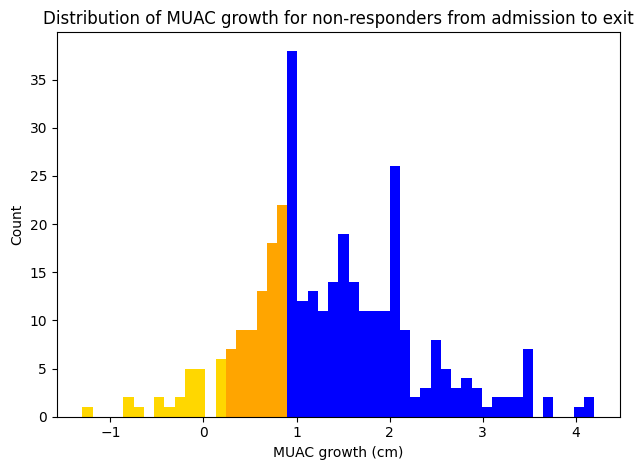

In [5]:
# Find the 25th percentile of growth of nonresponders
muac_q25 = muac_growth_df.query("status == 'nonresponse'")[
    "muac_weekly_change"
].quantile(0.25)

# Show the distribution, highlighting percentiles and comparing to the paper
paper_q25 = 0.2
n, bins, patches = plt.hist(
    muac_growth_df.query("status == 'nonresponse'")["muac_weekly_change"], bins=50
)
for bin_value, patch in zip(bins, patches):
    if bin_value <= paper_q25:
        patch.set_facecolor("gold")
    elif bin_value <= muac_q25:
        patch.set_facecolor("orange")
    else:
        patch.set_facecolor("blue")

plt.xlabel("MUAC growth (cm)")
plt.ylabel("Count")
plt.title("Distribution of MUAC growth for non-responders from admission to exit")
plt.tight_layout()

Taimaka's 25th percentile of growth in the non-response group is 8mm, which is higher than the value of 2mm found in the paper. I wouldn't over-interpret this difference though; the non-response groups are relatively small, and quantiles become noisy estimates the further they are measured from the median, so the different may be explained due to random variability of patients in a small sample. Moving forward in this notebook, I'll use the 8mm cutoff to define low- and high-growth non-responders, but I am happy to repeat the analysis with a different cutoff value.

In [6]:
# label patients with these new granular labels
muac_growth_df.loc[
    (muac_growth_df["status"] == "nonresponse")
    & (muac_growth_df["muac_weekly_change"] < muac_q25),
    "status_granular",
] = "low-growth nonresponse"

muac_growth_df.loc[
    (muac_growth_df["status"] == "nonresponse")
    & (muac_growth_df["muac_weekly_change"] >= muac_q25),
    "status_granular",
] = "high-growth nonresponse"

muac_growth_df.loc[muac_growth_df["status"] == "recovered", "status_granular"] = (
    "recovered"
)

# join patient-level labels back to the weekly data
raw_df = raw_df.merge(
    muac_growth_df[["pid", "status_granular"]].dropna().drop_duplicates(),
    on="pid",
    how="left",
    validate="m:1",
)

100%|███████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 1476.51it/s]


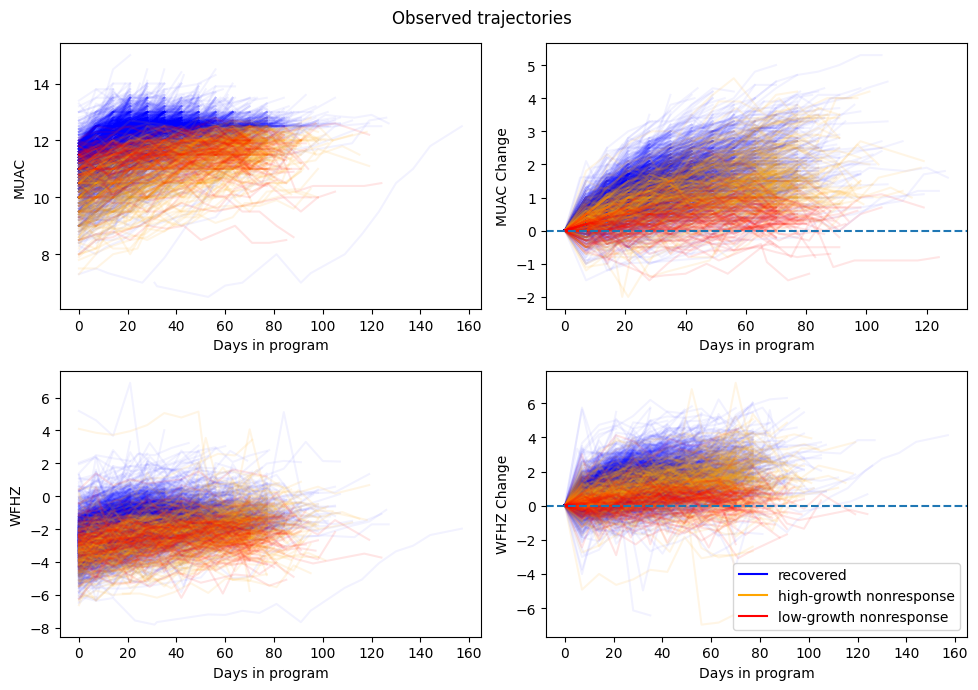

In [7]:
# Now plot trajectories by group.
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

colors = ["blue", "orange", "red"]
statuses = ["recovered", "high-growth nonresponse", "low-growth nonresponse"]
for color, status in zip(colors, statuses):
    alpha = 0.05 if color == "blue" else 0.1
    sub_df = raw_df[raw_df["status_granular"] == status]
    for i, pid in tqdm(
        enumerate(sub_df["pid"].unique()), total=len(sub_df["pid"].unique())
    ):
        df = sub_df[sub_df["pid"] == pid].sort_values("days_in_program")
        ax[0, 0].plot(
            df["days_in_program"],
            df["muac_weekly"],
            color=color,
            alpha=alpha,
        )
        ax[0, 1].plot(
            df["days_in_program"],
            df["muac_change"],
            color=color,
            alpha=alpha,
        )
        ax[1, 0].plot(
            df["days_in_program"],
            df["wfhz"],
            color=color,
            alpha=alpha,
        )
        ax[1, 1].plot(
            df["days_in_program"],
            df["wfhz_change"],
            color=color,
            alpha=alpha,
            label=status if i == 0 else None,
        )

ax[0, 1].axhline(0, linestyle="dashed")
ax[1, 1].axhline(0, linestyle="dashed")

ax[0, 0].set_xlabel("Days in program")
ax[0, 0].set_ylabel("MUAC")

ax[0, 1].set_xlabel("Days in program")
ax[0, 1].set_ylabel("MUAC Change")
ax[1, 0].set_xlabel("Days in program")
ax[1, 0].set_ylabel("WFHZ")
ax[1, 1].set_xlabel("Days in program")
ax[1, 1].set_ylabel("WFHZ Change")
lg = ax[1, 1].legend(loc="lower right")
for lh in lg.legend_handles:
    lh.set_alpha(1)

plt.suptitle("Observed trajectories")
plt.tight_layout()

While there is significant variability of the overall magnitude of these trajectories across patients, it does look like they are relatively parallel. Looking at the MUAC trajectories, patients who recover tend to have a higher overall MUAC value throughout the program. Looking at the change in MUAC, each group may have different slopes, but patients within each group tend to have similar slopes.

## Modeling: nonlinear regression with random intercepts

The above analysis suggests that linear mixed models, a common tool in longitudinal analysis, are appropriate here. Specifically, we want to fit a model with three characteristics:
1. Each patient gets their own intercept
2. All patients within statuses have parallel trajectories
3. Each status gets its own average trajectory

Getting mathy for a second, linear mixed models can be represented generally as

$\mathbf{y} | \mathbf{u} \sim N(\mathbf{X\beta} + \mathbf{Zu}, \sigma^2 \mathbf{I}_{n})$

$\mathbf{u} \sim N(0, \tau^2\mathbf{I}_{m})$

$y$ is the long vector $[y_i(t)]_{i,t}$ of the anthropometric for patient $i$ at time $t$, $\mathbf{X}$ is the design matrix of fixed effect features with $\mathbf{\beta}$ the corresponding coefficients, and  $\mathbf{Z}$ is the design matrix for the random effects $\mathbf{u}$.

For a "random intercepts" model in which every patient has their own intercept but shares a temporal trend, $\mathbf{X}$ will contain only two columns (the intercept and the time variable), and $\mathbf{Z}$ will be a $n \times m$ matrix of zeros and ones, where $Z[i, j]$ is one if observation $i$ corresponds to patient $j$, and zero otherwise. Then $\mathbf{u}$ are the patient-specific intercepts.

Extending this to nonlinear models is easy; just add nonlinear transformations of the linear features to $\mathbf{X}$. Similarly with categorical variables and interaction terms; we can add those as well.

In [8]:
# remove missing data, keeping rows relevant for the MUAC analysis
muac_df = raw_df.dropna(
    subset=["muac_weekly", "days_in_program", "status_granular", "pid"]
)
muac_trajectories = AnthropometricTrajectories()
muac_trajectories.fit(muac_df, "muac_weekly", cat_col="status_granular")

# repeat for WFHZ
wfhz_df = raw_df.dropna(subset=["wfhz", "days_in_program", "status_granular", "pid"])
wfhz_trajectories = AnthropometricTrajectories()
wfhz_trajectories.fit(wfhz_df, "wfhz", cat_col="status_granular")

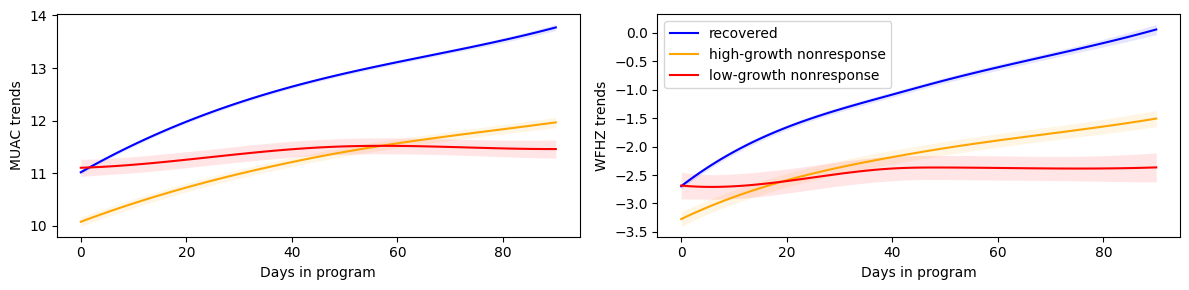

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

for color, status in zip(colors, statuses):
    tg = np.linspace(0, 90, 100)
    x_grid = muac_trajectories.create_design_matrix(
        tg, cat_vector=np.repeat(status, len(tg)), cat_labels=sorted(statuses)
    )
    m_pred = (x_grid @ muac_trajectories.params["beta"]).squeeze()
    w_pred = (x_grid @ wfhz_trajectories.params["beta"]).squeeze()

    sdm = np.sqrt(np.diag(x_grid @ muac_trajectories.params["cov_beta"] @ x_grid.T))
    sdw = np.sqrt(np.diag(x_grid @ wfhz_trajectories.params["cov_beta"] @ x_grid.T))

    ax[0].fill_between(
        tg,
        m_pred - 1.96 * sdm,
        m_pred + 1.96 * sdm,
        color=color,
        alpha=0.1,
        linewidth=0,
    )
    ax[0].plot(tg, m_pred, color=color)
    ax[1].fill_between(
        tg,
        w_pred - 1.96 * sdw,
        w_pred + 1.96 * sdw,
        color=color,
        alpha=0.1,
        linewidth=0,
    )
    ax[1].plot(tg, w_pred, color=color, label=status)

ax[0].set_xlabel("Days in program")
ax[0].set_ylabel("MUAC trends")
ax[1].set_xlabel("Days in program")
ax[1].set_ylabel("WFHZ trends")
ax[1].legend()
plt.tight_layout()

For comparison, here is the same analysis from the paper:

![a](paper.png)

The trends are basically the same! Recovered and high-growth patients have parallel trajectories but are offset by roughly one centimeter. Low-growth patients begin on average with similar metrics to those who recover, but do not show the same growth over time. Taimaka's patients can be categorized similarly to those in the paper, and, on average, the groups follow similar trajectories.

# Predict for new patient

Here is the fun part. When we get a new patient and want to forecast the trajectory, we can't immediately do that because we don't know that patient's intercept. But, given any amount of observations, we can estimate it and quantify the uncertainty around that estimate. Suppose we observe some anthropometrics $y_{new, t}$ for a new patient. 

Let $z_{new,t}=y_{new, t} - \mathbf{X}_{new} \hat{\beta}$. Our model is

$\mathbf{z}_{new} | u_{new} \sim N(u_{new}\mathbf{1}, \hat{\sigma}^2 \mathbf{I})$

$u_{new} \sim N(0, \hat{\tau}^2)$

so using Bayes' rule,

$u_{new} | \mathbf{z}_{new} \sim N\left(\frac{\hat{\tau}^2}{\frac{\hat{\sigma}^2}{n} + \hat{\tau}^2}\bar{z}, \frac{1}{\frac{n}{\hat{\sigma}^2} + \frac{1}{\hat{\tau}^2}}\right)$

so let $\hat{u}_{new} = \frac{\hat{\tau}^2}{\frac{\hat{\sigma}^2}{n} + \hat{\tau}^2}\bar{z}$ and $\hat{v}^2_{new} = \frac{1}{\frac{n}{\hat{\sigma}^2} + \frac{1}{\hat{\tau}^2}}$, then

$y_{new, t} \sim N(\hat{u}_{new} + \mathbf{X}_{new} \hat{\beta}, \hat{v}^2_{new} + \hat{\sigma}^2)$.

We can even take this a step further. Suppose some categorical feature was included in $\mathbf{X}$ when the model was trained (for example, whether the patient will recover or not), but when a new patient arrives, we don't yet know this value. Then we can loop over all possible values of this categorical feature, assume it, and compute the likelihood of this patient's trajectory given that assumption. Then the probability that this patient is in a given category is just the likelihood of that category divided by the sum of the likelihoods across all categories.

In [10]:
q = 1.645
colors = {
    "recovered": "blue",
    "low-growth nonresponse": "red",
    "high-growth nonresponse": "orange",
}


def plot_forecast(df):
    if "status_granular" in df.columns:
        df = df.drop(columns="status_granular")

    for n in range(1, df.shape[0] + 1):
        muac_forecast_df = muac_trajectories.forecast(df[:n])
        muac_forecast = muac_forecast_df["forecast"]
        muac_sd = muac_forecast_df["std"]
        pred_muac_status = muac_forecast_df["category"].values[0]
        pred_muac_prob = muac_forecast_df["posterior_probability"].values[0]

        wfhz_forecast_df = wfhz_trajectories.forecast(df[:n])
        wfhz_forecast = wfhz_forecast_df["forecast"]
        wfhz_sd = wfhz_forecast_df["std"]
        pred_wfhz_status = wfhz_forecast_df["category"].values[0]
        pred_wfhz_prob = wfhz_forecast_df["posterior_probability"].values[0]

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        ax[0].fill_between(
            np.linspace(0, 90, 100),
            muac_forecast - q * muac_sd,
            muac_forecast + q * muac_sd,
            color=colors[pred_muac_status],
            alpha=0.1,
            linewidth=0,
        )
        ax[0].plot(
            df["days_in_program"][:n],
            df["muac_weekly"][:n],
            color="black",
            label="observed",
            linestyle="dashed",
        )
        ax[0].scatter(df["days_in_program"][:n], df["muac_weekly"][:n], color="black")
        ax[0].plot(
            np.linspace(0, 90, 100),
            muac_forecast,
            color=colors[pred_muac_status],
            label="forecast",
        )
        ax[0].set_xlabel("Days in program")
        ax[0].set_ylabel("MUAC")
        ax[0].legend(title=f"PID {df['pid'].unique().item()}", loc="lower right")
        ax[0].set_ylim(7, 14)
        ax[0].set_title(
            f"{pred_muac_prob*100:.0f}% chance {pred_muac_status}",
            fontsize=10,
        )

        ax[1].fill_between(
            np.linspace(0, 90, 100),
            wfhz_forecast - q * wfhz_sd,
            wfhz_forecast + q * wfhz_sd,
            color=colors[pred_wfhz_status],
            alpha=0.1,
            linewidth=0,
        )
        ax[1].plot(
            df["days_in_program"][:n], df["wfhz"][:n], color="black", linestyle="dashed"
        )
        ax[1].scatter(df["days_in_program"][:n], df["wfhz"][:n], color="black")
        ax[1].plot(
            np.linspace(0, 90, 100),
            wfhz_forecast,
            color=colors[pred_wfhz_status],
        )
        ax[1].set_xlabel("Days in program")
        ax[1].set_ylabel("WFHZ")
        ax[1].set_ylim(-6, 1)
        ax[1].set_title(
            f"{pred_wfhz_prob*100:.0f}% chance {pred_wfhz_status}",
            fontsize=10,
        )

        label = "Visit" if n == 1 else "Visits"
        plt.suptitle(f"{n} {label}")
        plt.tight_layout()

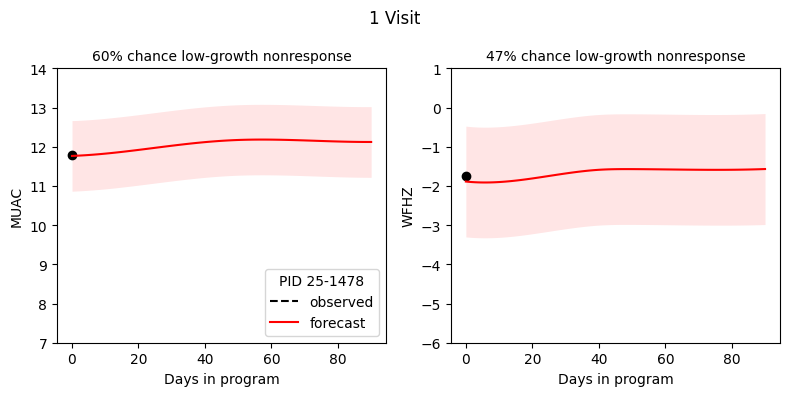

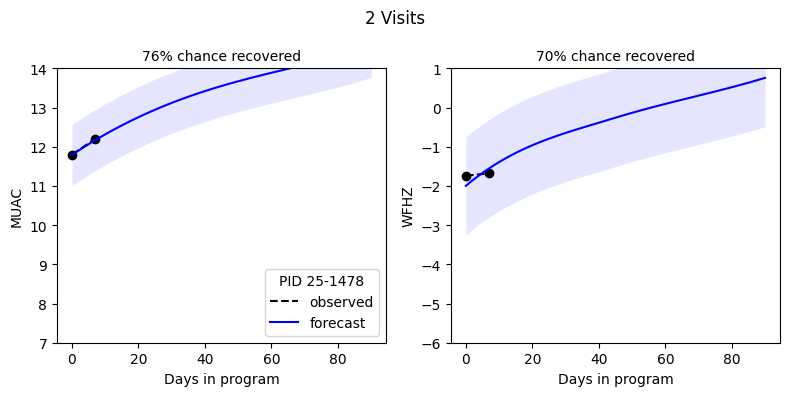

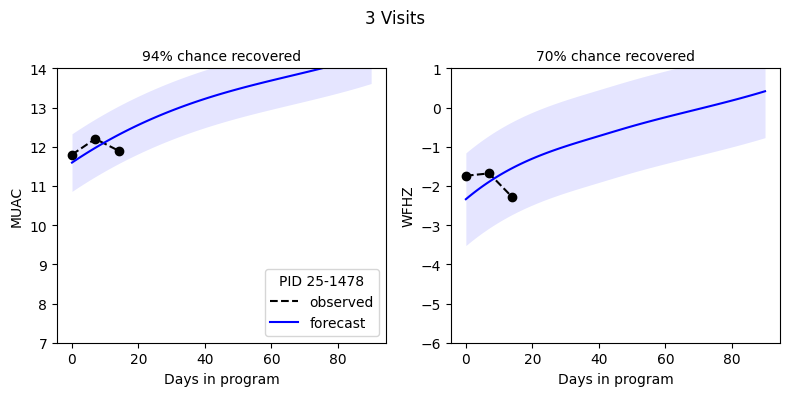

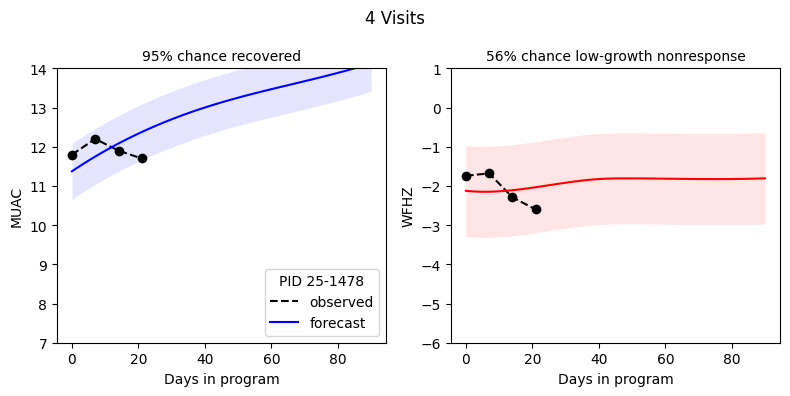

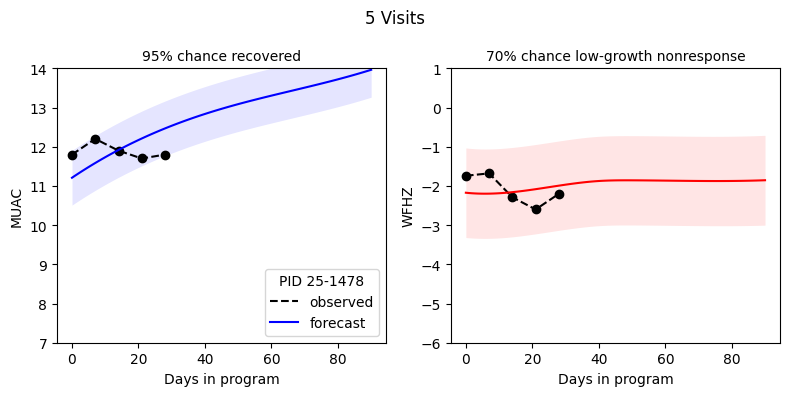

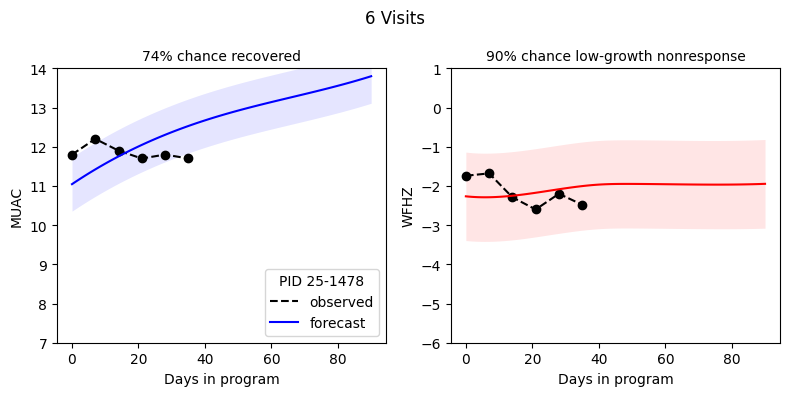

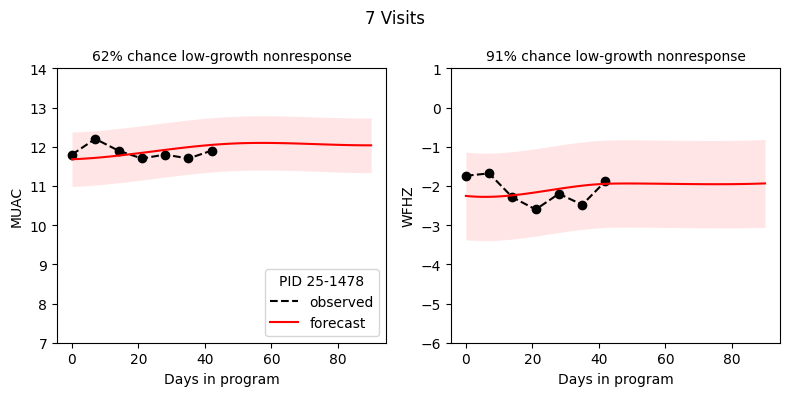

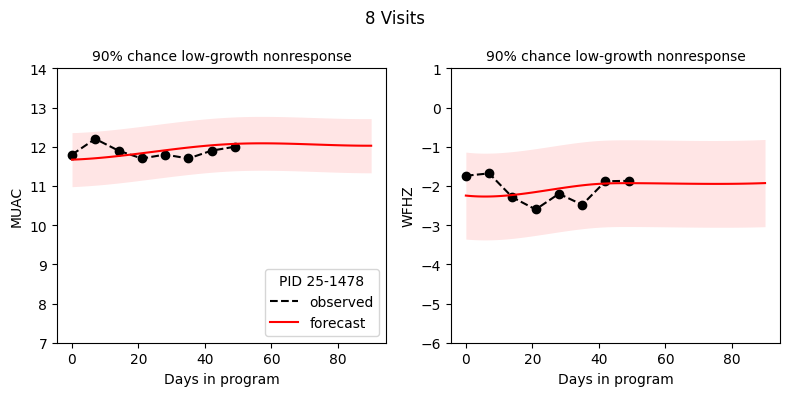

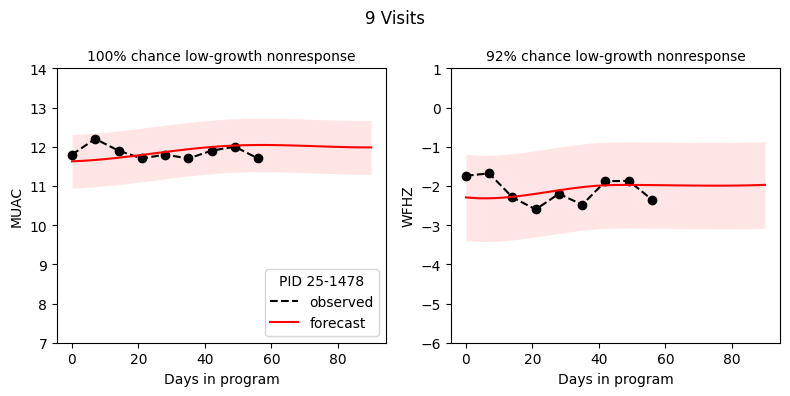

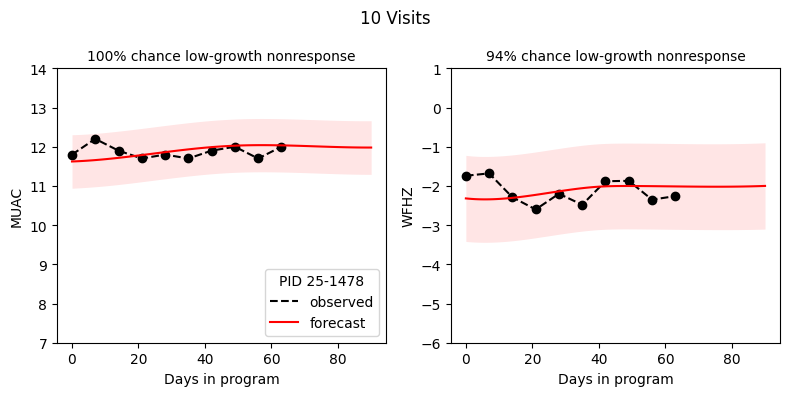

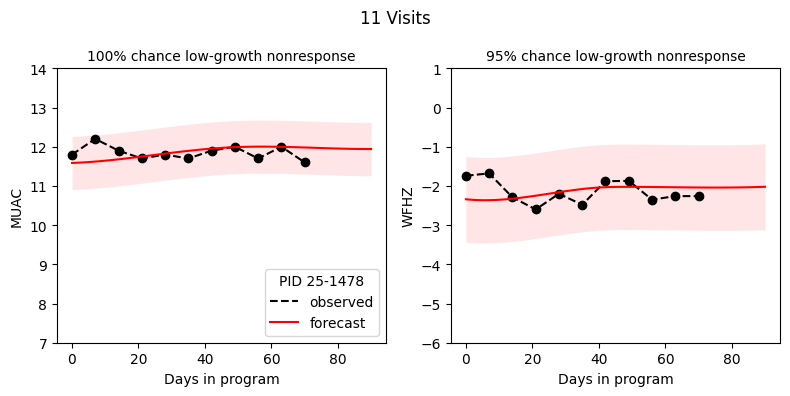

In [11]:
plot_forecast(df)